# Finding the best international scorers

### Purpose

Identify top scorers in international men's football but weight each goal by the quality of opposition (using FIFA World Rankings).

### Output

One row per player (player details, number of goals scored, weighted number of goals)

Intermediate output: one row per goal (match details, player details, ranking details of both teams)

### Data

- World rankings (1992 onwards): https://www.kaggle.com/datasets/cashncarry/fifaworldranking?select=fifa_ranking-2024-04-04.csv
- Scorers: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?select=goalscorers.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

scorers = pd.read_csv("./data/goalscorers.csv", parse_dates=["date"])
print(scorers.shape)
scorers.head()

(44227, 8)


,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False


## Clean scorers data

In [5]:
scorers.isnull().sum()

date           0
home_team      0
away_team      0
team           0
scorer        49
minute       259
own_goal       0
penalty        0
dtype: int64

In [6]:
scorers[scorers["scorer"].isnull()]

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
8697,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8698,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8699,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8700,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8701,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8702,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8703,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8704,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False
8705,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False
8706,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False


These are some games in 1980 with unknown scorers. We can't calculate anything if we don't know the scorer, so drop these rows.

In [7]:
scorers["own_goal"].value_counts(normalize=True)

own_goal
False    0.981572
True     0.018428
Name: proportion, dtype: float64

Own goals don't count, drop those

In [8]:
scorers_clean = (
    scorers
    .dropna()
    .query("own_goal == False")
    # calculate the opponent
    .assign(opponent=lambda df_: np.where(df_["home_team"] == df_["team"], df_["away_team"], df_["home_team"]))
)

scorers_clean.head()

,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False,Chile
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False,Chile
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False,Chile
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False,Chile
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False,Chile


## Rankings data

In [9]:
rankings = pd.read_csv("./data/fifa_ranking-2024-06-20.csv", parse_dates=["rank_date"])
print(rankings.shape)
rankings.head()

(67472, 8)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,140.0,Brunei Darussalam,BRU,2.0,0.0,140,AFC,1992-12-31
1,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
2,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
3,31.0,Greece,GRE,38.0,0.0,31,UEFA,1992-12-31
4,30.0,Algeria,ALG,39.0,0.0,30,CAF,1992-12-31


In [10]:
rankings.isnull().sum()

rank               9
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [11]:
rankings[rankings["rank"].isnull()]

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
66339,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-10-26
66340,NaN,Tonga,TGA,861.81,0.0,0,OFC,2023-10-26
66341,NaN,Samoa,SAM,894.26,0.0,0,OFC,2023-10-26
66342,NaN,American Samoa,ASA,900.27,0.0,0,OFC,2023-10-26
66493,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-11-30
66734,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-12-21
66919,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2024-02-15
67134,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2024-04-04
67393,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2024-06-20


Unclear why these don't have rankings, but we need that information, so drop these rows.

In [12]:
rankings["rank_date"].unique()

<DatetimeArray>
['1992-12-31 00:00:00', '1993-08-08 00:00:00', '1993-09-23 00:00:00',
 '1993-10-22 00:00:00', '1993-11-19 00:00:00', '1993-12-23 00:00:00',
 '1994-02-15 00:00:00', '1994-03-15 00:00:00', '1994-04-19 00:00:00',
 '1994-05-17 00:00:00',
 ...
 '2023-04-06 00:00:00', '2023-06-29 00:00:00', '2023-07-20 00:00:00',
 '2023-09-21 00:00:00', '2023-10-26 00:00:00', '2023-11-30 00:00:00',
 '2023-12-21 00:00:00', '2024-02-15 00:00:00', '2024-04-04 00:00:00',
 '2024-06-20 00:00:00']
Length: 333, dtype: datetime64[ns]

Updates look sporadic, certainly not regular or annual. To be able to join a goal to the ranking data based on date, each ranking record needs a "start date" and "end date".

In [15]:
rankings_clean = (
    rankings
    .dropna()
    .sort_values(["country_full", "rank_date"]) # sort by country and date so we can work out "next ranking date"
    .assign(
        start_date=lambda df_: df_["rank_date"],
        end_date=lambda df_: (df_["rank_date"].shift(-1) + datetime.timedelta(days=-1)).fillna(datetime.datetime.today())
    )
)

rankings_clean.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date
19682,204.0,Afghanistan,AFG,7.0,0.0,204,AFC,2003-01-15,2003-01-15,2003-02-18
19862,203.0,Afghanistan,AFG,9.0,7.0,-1,AFC,2003-02-19,2003-02-19,2003-03-25
20235,198.0,Afghanistan,AFG,48.0,9.0,-5,AFC,2003-03-26,2003-03-26,2003-04-22
20296,198.0,Afghanistan,AFG,48.0,48.0,0,AFC,2003-04-23,2003-04-23,2003-05-20
20578,199.0,Afghanistan,AFG,48.0,48.0,1,AFC,2003-05-21,2003-05-21,2003-06-24


## Merge the two

We want to merge on:
- country name
- date (the date of the goal needs to fall in between a start and end date of a ranking record)

In `pandas`, we need to do this by joining the datasets on country alone and filtering out instances where the dates don't match.

In [16]:
def get_scorer_with_country(row):
    return f"{row['scorer']} ({row['team']})"

scorers_merged = (
    scorers_clean
    .merge(rankings_clean, left_on="opponent", right_on="country_full")
    .query("date >= start_date and date <= end_date")
    .rename(columns={
        "rank": "opponent_ranking"
    })
    .assign(scorer_with_country=lambda df_: df_.apply(get_scorer_with_country, axis=1))
)

print(scorers_merged.shape)

scorers_merged.head()

(27704, 20)


,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent,opponent_ranking,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date,scorer_with_country
112554,1993-06-18,Paraguay,Chile,Paraguay,Roberto Cabañas,6.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Roberto Cabañas (Paraguay)
112887,1993-06-21,Brazil,Chile,Brazil,Müller,36.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Müller (Brazil)
113220,1993-06-21,Brazil,Chile,Brazil,Palhinha,55.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Palhinha (Brazil)
113553,1993-06-24,Chile,Peru,Peru,José del Solar,14.0,False,True,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,José del Solar (Peru)
113905,1995-07-08,United States,Chile,United States,Eric Wynalda,14.0,False,False,Chile,42.0,Chile,CHI,39.0,36.0,-7,CONMEBOL,1995-06-13,1995-06-13,1995-07-24,Eric Wynalda (United States)


## Find top scorers!

First let's find the average opponent rank for each scorer.

In [17]:
scorers_merged.groupby("scorer")["opponent_ranking"].mean().sort_values()

scorer
Frickson Erazo          1.0
Ramon Menezes           1.0
Isaac Terrazas          1.0
Stefan de Vrij          1.0
Patricio Urrutia        1.0
                      ...  
Robert Kirss          211.0
Taijo Teniste         211.0
Kostakis Artymatas    211.0
Jan Busuttil          211.0
Maxim Fedin           211.0
Name: opponent_ranking, Length: 8604, dtype: float64

This doesn't work because players can score a single goal for their country and look really good in these statistics.

Let's only include players who scored at least N goals, but what should N be?

In [19]:
goals_by_player = (
    scorers_merged["scorer"]
    .value_counts()
    .reset_index()
)

goals_by_player.head()

,scorer,count
0,Cristiano Ronaldo,104
1,Romelu Lukaku,57
2,Robert Lewandowski,56
3,Harry Kane,53
4,Lionel Messi,52


That's too low for Messi (and possibly others). Let's investigate...

In [21]:
# Messi's goals per year
# cross-reference against https://en.wikipedia.org/wiki/List_of_international_goals_scored_by_Lionel_Messi
(
    scorers_merged[scorers_merged["scorer"] == "Lionel Messi"]
    .set_index("date")
    .resample("YS")
    .size()
)

date
2006-01-01    1
2007-01-01    4
2008-01-01    1
2009-01-01    1
2010-01-01    0
2011-01-01    2
2012-01-01    5
2013-01-01    3
2014-01-01    3
2015-01-01    1
2016-01-01    7
2017-01-01    4
2018-01-01    1
2019-01-01    1
2020-01-01    1
2021-01-01    9
2022-01-01    8
Freq: AS-JAN, dtype: int64

In [22]:
scorers_merged[scorers_merged["scorer"] == "Lionel Messi"].sort_values("date")

,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent,opponent_ranking,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date,scorer_with_country
12054487,2006-06-16,Argentina,Serbia,Argentina,Lionel Messi,88.0,False,False,Serbia,47.0,Serbia,SRB,612.00,0.00,47,UEFA,2005-12-16,2005-12-16,2006-07-11,Lionel Messi (Argentina)
3447113,2007-07-08,Argentina,Peru,Argentina,Lionel Messi,61.0,False,False,Peru,64.0,Peru,PER,480.00,442.00,-7,CONMEBOL,2007-06-13,2007-06-13,2007-07-17,Lionel Messi (Argentina)
3699527,2007-07-11,Mexico,Argentina,Argentina,Lionel Messi,61.0,False,False,Mexico,26.0,Mexico,MEX,866.00,891.00,6,CONCACAF,2007-06-13,2007-06-13,2007-07-17,Lionel Messi (Argentina)
8090869,2007-10-16,Venezuela,Argentina,Argentina,Lionel Messi,43.0,False,False,Venezuela,58.0,Venezuela,VEN,521.00,540.00,2,CONMEBOL,2007-09-19,2007-09-19,2007-10-23,Lionel Messi (Argentina)
5138515,2007-11-20,Colombia,Argentina,Argentina,Lionel Messi,36.0,False,False,Colombia,25.0,Colombia,COL,801.00,862.00,1,CONMEBOL,2007-10-24,2007-10-24,2007-11-21,Lionel Messi (Argentina)
606897,2008-10-11,Argentina,Uruguay,Argentina,Lionel Messi,6.0,False,False,Uruguay,20.0,Uruguay,URU,887.00,817.00,-2,CONMEBOL,2008-10-08,2008-10-08,2008-11-11,Lionel Messi (Argentina)
8096548,2009-03-28,Argentina,Venezuela,Argentina,Lionel Messi,26.0,False,False,Venezuela,65.0,Venezuela,VEN,498.00,492.00,-2,CONMEBOL,2009-03-11,2009-03-11,2009-04-07,Lionel Messi (Argentina)
162709,2011-10-07,Argentina,Chile,Argentina,Lionel Messi,25.0,False,False,Chile,14.0,Chile,CHI,932.00,960.00,3,CONMEBOL,2011-09-21,2011-09-21,2011-10-18,Lionel Messi (Argentina)
5145888,2011-11-15,Colombia,Argentina,Argentina,Lionel Messi,61.0,False,False,Colombia,30.0,Colombia,COL,757.00,738.00,-2,CONMEBOL,2011-10-19,2011-10-19,2011-11-22,Lionel Messi (Argentina)
4998043,2012-06-02,Argentina,Ecuador,Argentina,Lionel Messi,31.0,False,False,Ecuador,37.0,Ecuador,ECU,679.00,673.00,0,CONMEBOL,2012-05-09,2012-05-09,2012-06-05,Lionel Messi (Argentina)


Let's find Messi's missing goals

In [29]:
import requests
from io import StringIO

messi_goals_wiki_url = "https://en.wikipedia.org/wiki/List_of_international_goals_scored_by_Lionel_Messi"
messi_goals_html = requests.get(messi_goals_wiki_url)

messi_goals_html.raise_for_status()

wiki_frames = pd.read_html(StringIO(messi_goals_html.text))

In [32]:
messi_goals = wiki_frames[1].copy()
messi_goals["Competition"].value_counts()

Competition
Friendly                             50
2014 FIFA World Cup qualification    10
2018 FIFA World Cup qualification     7
2022 FIFA World Cup qualification     7
2022 FIFA World Cup                   5
Copa América Centenario               5
2014 FIFA World Cup                   4
2010 FIFA World Cup qualification     4
2021 Copa América                     4
2026 FIFA World Cup qualification     3
2007 Copa América                     2
2022 FIFA World Cup final             2
2015 Copa América                     1
2006 FIFA World Cup                   1
2018 FIFA World Cup                   1
2019 Copa América                     1
2019 Superclásico de las Américas     1
Name: count, dtype: int64

Looks like we're potentially missing most goals scored in friendlies.

If that's true, as long as it affects everyone the same way, and/or we're happy to say goals that mattered (e.g. in a tournament) count for more.

So we can't just weight each *goal* (because we don't have all goals), but we can filter the result to players who have > N goals and see the **average opponent rating**.

Another option to help with this problem is to enhance the data with match info and **explicitly remove friendlies**. We might not want to do that if we had all the data, but with what we have it might be better to say we will exclude friendly games.

In [36]:
matches = pd.read_csv("./data/results.csv", parse_dates=["date"])
print(matches.shape)
matches.head()

(47381, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [40]:
print(len(scorers_merged))
merged_with_matches = scorers_merged.merge(matches, on=["date", "home_team", "away_team"])
print(len(merged_with_matches))

merged_with_matches.head()

27704
27704


,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent,opponent_ranking,...,rank_date,start_date,end_date,scorer_with_country,home_score,away_score,tournament,city,country,neutral
0,1993-06-18,Paraguay,Chile,Paraguay,Roberto Cabañas,6.0,False,False,Chile,47.0,...,1992-12-31,1992-12-31,1993-08-07,Roberto Cabañas (Paraguay),1.0,0.0,Copa América,Cuenca,Ecuador,True
1,1993-06-21,Brazil,Chile,Brazil,Müller,36.0,False,False,Chile,47.0,...,1992-12-31,1992-12-31,1993-08-07,Müller (Brazil),2.0,3.0,Copa América,Cuenca,Ecuador,True
2,1993-06-21,Brazil,Chile,Brazil,Palhinha,55.0,False,False,Chile,47.0,...,1992-12-31,1992-12-31,1993-08-07,Palhinha (Brazil),2.0,3.0,Copa América,Cuenca,Ecuador,True
3,1993-06-21,Brazil,Chile,Chile,José Luis Sierra,15.0,False,False,Brazil,3.0,...,1992-12-31,1992-12-31,1993-08-07,José Luis Sierra (Chile),2.0,3.0,Copa América,Cuenca,Ecuador,True
4,1993-06-21,Brazil,Chile,Chile,Richard Zambrano,51.0,False,False,Brazil,3.0,...,1992-12-31,1992-12-31,1993-08-07,Richard Zambrano (Chile),2.0,3.0,Copa América,Cuenca,Ecuador,True


In [41]:
merged_with_matches["tournament"].value_counts()

tournament
FIFA World Cup qualification      15361
UEFA Euro qualification            5316
FIFA World Cup                     1102
African Cup of Nations             1097
UEFA Nations League                1091
Gold Cup                            840
Copa América                        777
AFC Asian Cup                       641
UEFA Euro                           598
Oceania Nations Cup                 383
Confederations Cup                  370
Baltic Cup                          124
CONMEBOL–UEFA Cup of Champions        4
Name: count, dtype: int64

No friendlies? That might mean friendlies are already excluded from the goalscorers data.

We can verify this by seeing if there were any friendlies in the raw match data:

In [42]:
matches["tournament"].value_counts()

tournament
Friendly                                17978
FIFA World Cup qualification             8169
UEFA Euro qualification                  2824
African Cup of Nations qualification     2124
FIFA World Cup                            964
                                        ...  
TIFOCO Tournament                           1
Copa Confraternidad                         1
ConIFA Challenger Cup                       1
Évence Coppée Trophy                        1
Benedikt Fontana Cup                        1
Name: count, Length: 175, dtype: int64

Yes! The matches data has friendlies, but the goalscorers data does not.

We can proceed with the data we have with the knowledge that we're looking at only goals scored in games that weren't friendlies.

In [44]:
MIN_GOALS = 20
N_TOP = 20

players_to_consider = goals_by_player.loc[goals_by_player["count"] > MIN_GOALS, "scorer"].to_list()

top_players = (
    scorers_merged
    .query("scorer in @players_to_consider")
    .groupby("scorer_with_country")
    ["opponent_ranking"]
    .mean() # mean over median because outliers are informative i.e. when a player scores against a really good or bad team
    .sort_values()
    .head(N_TOP)
)

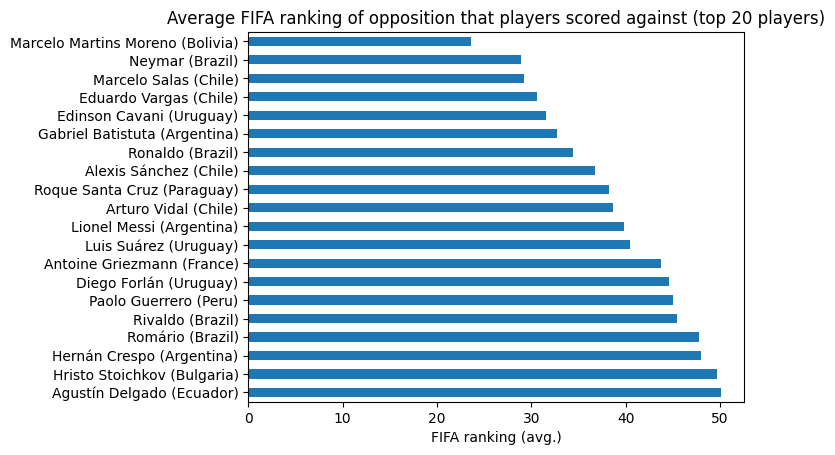

In [45]:
fig, axis = plt.subplots()

(
    top_players
    .sort_values(ascending=False)
    .plot
    .barh(ax=axis)
)

axis.set(
    title=f"Average FIFA ranking of opposition that players scored against (top {N_TOP} players)",
    xlabel="FIFA ranking (avg.)",
    ylabel=None
)

plt.show()

Looks like the "best" scorers according to this metric will be in South America because players tend to play against better opponents (there are fewer San Marinos and Luxembourgs in South America).

Let's look at the average ranking per continent:

In [46]:
rankings_clean

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date
19682,204.0,Afghanistan,AFG,7.00,0.00,204,AFC,2003-01-15,2003-01-15,2003-02-18 00:00:00.000000
19862,203.0,Afghanistan,AFG,9.00,7.00,-1,AFC,2003-02-19,2003-02-19,2003-03-25 00:00:00.000000
20235,198.0,Afghanistan,AFG,48.00,9.00,-5,AFC,2003-03-26,2003-03-26,2003-04-22 00:00:00.000000
20296,198.0,Afghanistan,AFG,48.00,48.00,0,AFC,2003-04-23,2003-04-23,2003-05-20 00:00:00.000000
20578,199.0,Afghanistan,AFG,48.00,48.00,1,AFC,2003-05-21,2003-05-21,2003-06-24 00:00:00.000000
...,...,...,...,...,...,...,...,...,...,...
66583,124.0,Zimbabwe,ZIM,1144.56,1138.56,-1,CAF,2023-11-30,2023-11-30,2023-12-20 00:00:00.000000
66791,124.0,Zimbabwe,ZIM,1144.56,1144.56,0,CAF,2023-12-21,2023-12-21,2024-02-14 00:00:00.000000
66889,124.0,Zimbabwe,ZIM,1144.56,1144.56,0,CAF,2024-02-15,2024-02-15,2024-04-03 00:00:00.000000
67095,122.0,Zimbabwe,ZIM,1143.66,1144.56,-2,CAF,2024-04-04,2024-04-04,2024-06-19 00:00:00.000000


In [48]:
rankings_clean.groupby("confederation")["rank"].mean().sort_values()

confederation
CONMEBOL     35.038138
UEFA         61.839084
CAF         107.163600
AFC         125.083243
CONCACAF    128.386920
OFC         163.997294
Name: rank, dtype: float64

Average ranking of South American teams (all time) is 35, whereas in Europe it's 62.

What about min and max?

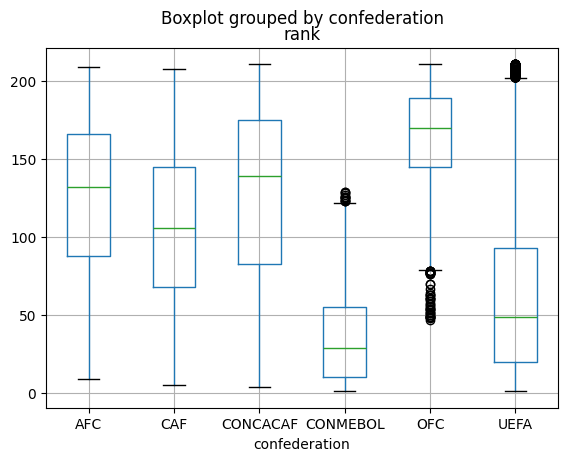

In [51]:
_ = rankings_clean.boxplot(column="rank", by="confederation")

This tells us that there is a bigger spread among European teams (e.g. San Marino) whereas a South American team has never been worse than ~130th in the world.

This means by definition South American goalscorers will be ranked higher by our metric.

Let's move on from averaging opponent rankings and include the **number of goals**.

We'll weight each goal by the inverse rank of the opponent (because lower is better).

What weight calculation should be use? If we use $\frac{1}{rank}$ then scoring against the top team will count as 1 goal and scoring against the second will count as 0.5. That feels too drastic.

We'll use "half a Gaussian" so the weight of a goal diminishes smoothly as an opponent gets "worse".

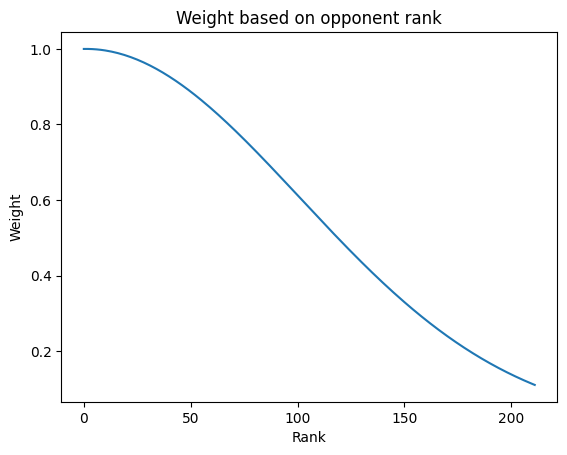

In [82]:
from scipy import stats

def get_weight(rank):
    """
    Get the weight to apply to a single goal based on the rank of the opposition.

    The rank is based on a Gaussian with mean=1, std=100
    """
    max_weight = stats.norm.pdf(x=1, loc=1, scale=100)
    
    return stats.norm.pdf(x=rank, loc=1, scale=100)/max_weight

# take a look at the weight function above
ranks = list(range(0, 212))

weights = [get_weight(r) for r in ranks]

fig, axis = plt.subplots()

_ = axis.plot(ranks, weights)

axis.set(
    title="Weight based on opponent rank",
    xlabel="Rank",
    ylabel="Weight"
)

plt.show()

Now apply this weighting function to all goals and sum up each player's weighted goals to get their "score".

In [86]:
scorers_merged["goal_weight"] = scorers_merged["opponent_ranking"].apply(get_weight)
scorers_merged.head()

,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent,opponent_ranking,...,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date,scorer_with_country,goal_weight
112554,1993-06-18,Paraguay,Chile,Paraguay,Roberto Cabañas,6.0,False,False,Chile,47.0,...,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Roberto Cabañas (Paraguay),0.899605
112887,1993-06-21,Brazil,Chile,Brazil,Müller,36.0,False,False,Chile,47.0,...,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Müller (Brazil),0.899605
113220,1993-06-21,Brazil,Chile,Brazil,Palhinha,55.0,False,False,Chile,47.0,...,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Palhinha (Brazil),0.899605
113553,1993-06-24,Chile,Peru,Peru,José del Solar,14.0,False,True,Chile,47.0,...,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,José del Solar (Peru),0.899605
113905,1995-07-08,United States,Chile,United States,Eric Wynalda,14.0,False,False,Chile,42.0,...,CHI,39.0,36.0,-7,CONMEBOL,1995-06-13,1995-06-13,1995-07-24,Eric Wynalda (United States),0.919385


Now just add this weighted value up per player (scorers of above N goals).

This is now no longer "average quality of opponent" but "total goals scored (weighted sum)"

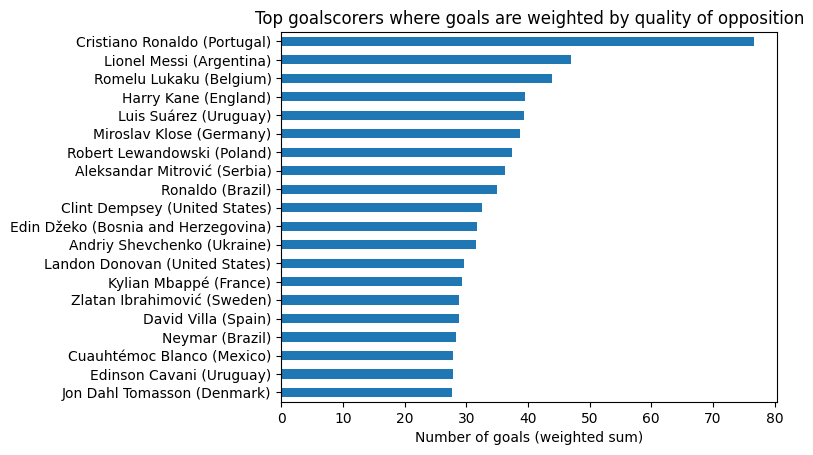

In [88]:
top_players_weighted = (
    scorers_merged
    .query("scorer in @players_to_consider")
    .groupby("scorer_with_country")
    ["goal_weight"]
    .sum()
    .sort_values(ascending=False) # this time, higher means better
    .head(N_TOP)
)

fig, axis = plt.subplots()

(
    top_players_weighted
    .sort_values()
    .plot
    .barh(ax=axis)
)

axis.set(
    title=f"Top goalscorers where goals are weighted by quality of opposition",
    xlabel="Number of goals (weighted sum)",
    ylabel=None
)

plt.show()

Finally, let's look at the difference between "raw number of goals" and the weighted version

In [93]:
top_players_stats = (
    scorers_merged
    .query("scorer in @players_to_consider")
    .groupby("scorer_with_country")
    .agg(raw_goals=('date', 'count'), weighted_sum=('goal_weight', 'sum'))
    .assign(diff=lambda df_: df_["raw_goals"] - df_["weighted_sum"])
    .sort_values("diff", ascending=False)
    #.head(N_TOP)
)

top_players_stats

,raw_goals,weighted_sum,diff
scorer_with_country,,,
Cristiano Ronaldo (Portugal),104,76.608078,27.391922
Robert Lewandowski (Poland),56,37.391767,18.608233
Edin Džeko (Bosnia and Herzegovina),49,31.821529,17.178471
Ali Mabkhout (United Arab Emirates),31,14.495639,16.504361
Archie Thompson (Australia),21,5.012315,15.987685
...,...,...,...
Gabriel Batistuta (Argentina),29,27.125313,1.874687
Neymar (Brazil),30,28.306574,1.693426
Eduardo Vargas (Chile),26,24.513833,1.486167


When you look at how many goals are "dropped" once you account for the quality of opposition, South American players drop the fewest goals (because they mostly play against better opposition) whereas European hotshots like CR drop 27 goals because they score against much weaker opposition.